# Visualize statistical results

This notebook was created as a companion notebook to the [Statitical API webinar](https://youtu.be/4JviobxqTO8).

## Import modules and authenticate at Sentinel Hub

In [24]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import requests
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sentinelhub import SentinelHubStatistical, DataCollection, CRS, BBox, bbox_to_dimensions, \
    Geometry, SHConfig, parse_time, parse_time_interval, SentinelHubStatisticalDownloadClient

In [25]:
# Replace the client ID and client secret below with your own
config = SHConfig()
client_id = "<your_client_id>"
client_secret = "<your_client_id>"

client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=client_id, client_secret=client_secret)

## Run a request: NDVI and BSI statistics with water pixels excluded

First, we run a statistical API request, to get the JSON result with statistics. The request  covers 1 year and has 10 day aggregation intervals. Statistics is calculated for 2 indices, NDVI and BSI (barren soil index), each returned in its own output. Additionally, water pixels were excluded from the calculation. 

In [26]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B02",
        "B04",
        "B08",
        "B11",
        "SCL",
        "CLM",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "ndvi",
        bands: ["NDVI"]
      },
      {
        id: "bsi",
        bands: ["BSI"]
      },
      {
        id: "dataMask",
        bands: 1
      }]
  }
}

function evaluatePixel(samples) {
    let ndvi = (samples.B08 - samples.B04)/(samples.B08 + samples.B04)
    let bsi = ((samples.B11 + samples.B04)-(samples.B08 + samples.B02))/((samples.B11 + samples.B04)+(samples.B08 + samples.B02));
     
    var validNDVIMask = 1
    if (samples.B08 + samples.B04 + samples.B11 + samples.B02 == 0 ){
        validNDVIMask = 0
    }
    
    var noWaterMask = 1
    if (samples.SCL == 6 ){
        noWaterMask = 0
    }

    return {
        ndvi: [ndvi],
        bsi: [bsi],
        // Exclude nodata pixels, pixels where ndvi is not defined and water pixels from statistics:
        dataMask: [samples.dataMask * validNDVIMask * noWaterMask]
    }
}
"""


stats_request = {
  "input": {
   "bounds": {
      "geometry": {
          "type": "Polygon",
          "coordinates": [
            [
              [
                458085.878866,
                5097236.833044
              ],
              [
                457813.834156,
                5096808.351383
              ],
              [
                457979.897062,
                5096313.767184
              ],
              [
                458146.639373,
                5096405.411294
              ],
              [
                458085.878866,
                5097236.833044
              ]
            ]
          ]
        },
    "properties": {
        "crs": "http://www.opengis.net/def/crs/EPSG/0/32633"
        }
    },
    "data": [
      {
        "type": "sentinel-2-l2a",
        "dataFilter": {
            "mosaickingOrder": "mostRecent",
            "maxCloudCoverage": 5
        }
      }
    ]
  },
  "aggregation": {
    "timeRange": {
        "from": "2020-08-01T00:00:00Z",
        "to": "2021-08-01T00:00:00Z"
      },
    "aggregationInterval": {
        "of": "P10D"
    },
    "evalscript": evalscript,
    "resx": 10,
    "resy": 10
  }
}

headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json'
}

url = "https://services.sentinel-hub.com/api/v1/statistics"

response = oauth.request("POST", url=url, headers=headers, json=stats_request)
sh_statistics = response.json()
sh_statistics

{'data': [{'interval': {'from': '2020-08-01T00:00:00Z',
    'to': '2020-08-11T00:00:00Z'},
   'outputs': {'bsi': {'bands': {'BSI': {'stats': {'min': -0.4044482707977295,
        'max': -0.09483614563941956,
        'mean': -0.27758398120354194,
        'stDev': 0.044207114056467496,
        'sampleCount': 3036,
        'noDataCount': 1192}}}},
    'ndvi': {'bands': {'NDVI': {'stats': {'min': 0.750795304775238,
        'max': 0.8925060033798218,
        'mean': 0.8437445996058478,
        'stDev': 0.017705930134783242,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-09-10T00:00:00Z', 'to': '2020-09-20T00:00:00Z'},
   'outputs': {'bsi': {'bands': {'BSI': {'stats': {'min': -0.4406079649925232,
        'max': -0.05410122126340866,
        'mean': -0.2468917381963866,
        'stDev': 0.050662497357656294,
        'sampleCount': 3036,
        'noDataCount': 1192}}}},
    'ndvi': {'bands': {'NDVI': {'stats': {'min': 0.7094070315361023,
        'm

## Find any value in JSON

### Follow the JSON nesting structure to return any value

To find any specific value, it's important to understand the nesting structure of the resulting JSON. Note that the path changes with different outputs and naming. 

**Third mean BSI value**

Here we find the mean BSI value of the third interval.

In [3]:
sh_statistics['data'][2]['outputs']['bsi']['bands']['BSI']['stats']['mean']

-0.017572231820642846

**First outputs content**

By ending our search sooner, we can check the content included in our JSON at any level. The following request returns the content of outputs in the first available interval. 

In [28]:
sh_statistics['data'][0]['outputs']

{'bsi': {'bands': {'BSI': {'stats': {'min': -0.4044482707977295,
     'max': -0.09483614563941956,
     'mean': -0.27758398120354194,
     'stDev': 0.044207114056467496,
     'sampleCount': 3036,
     'noDataCount': 1192}}}},
 'ndvi': {'bands': {'NDVI': {'stats': {'min': 0.750795304775238,
     'max': 0.8925060033798218,
     'mean': 0.8437445996058478,
     'stDev': 0.017705930134783242,
     'sampleCount': 3036,
     'noDataCount': 1192}}}}}

**From-To dates of the sixth interval**

The following request returns the from-to dates of the sixth available interval. 

In [30]:
sh_statistics['data'][5]['interval']

{'from': '2021-02-07T00:00:00Z', 'to': '2021-02-17T00:00:00Z'}

### Create loops to access all value instances 

To create a chart, that displays temporal NDVI changes for our parcel, we need to find every instance of e.g. mean NDVI and every corresponding date. To do so, we create a loop to check the content for all intervals and return the list of values we need.

**Find every instance of mean NDVI**

In [5]:
for data_item in sh_statistics['data']:
    for band, value in data_item['outputs']['ndvi']['bands'].items(): 
        print (value['stats']['mean'])    # Returns the contents of each band

0.8437445996058478
0.8138526516467535
0.6830975254775392
0.6844527571100473
0.516412826646887
0.609049283630678
0.3974006404037584
0.5439309637969332
0.5521596287116568
0.6712415874359907
0.800618395435578
0.9079555950557855
0.8276296372721363
0.8611833145458123


**Retrieve all the available TO dates**

In [34]:
for data_item in sh_statistics['data']:
    for band in data_item['outputs']['ndvi']['bands'].items():  # For each band found
        print(data_item['interval']['to'])   

2020-08-11T00:00:00Z
2020-09-20T00:00:00Z
2020-11-09T00:00:00Z
2020-11-29T00:00:00Z
2021-01-18T00:00:00Z
2021-02-17T00:00:00Z
2021-02-27T00:00:00Z
2021-03-09T00:00:00Z
2021-03-29T00:00:00Z
2021-04-08T00:00:00Z
2021-05-18T00:00:00Z
2021-06-17T00:00:00Z
2021-06-27T00:00:00Z
2021-07-07T00:00:00Z


## Display statistical data in a table

**Create empty arrays that will be filled with data later**

In [35]:
date = []
Mean = []
Min = []
Max = []

**Get NDVI statistics and TO dates**

Next, we create loops to access mean, max and min NDVI values for each interval, and append each to the previously created arrays. We do the same for TO dates. Note that we also formatted our dates to only include the first 10 strings. 

Finally, we print the arrays to inspect the values retrieved. 

In [6]:
# Find ndvi values
for data_item in sh_statistics['data']:
    for band, value in data_item['outputs']['ndvi']['bands'].items(): 
        Mean.append(value ['stats']['mean'])            # Find mean values and append them to the mean array  
        Max.append(value ['stats']['max'])              # Find max values and append them to the max array                                  
        Min.append(value ['stats']['min'])              # Find min values and append them to the min array

# Find "date to" for each ndvi entry
for data_item in sh_statistics['data']:
    for band in data_item['outputs']['ndvi']['bands'].items():  # For each band found
        date.append(data_item['interval']['to'])                # Find and append "date to" values to the date array
        date[:] = (elem[:10] for elem in date)                  # Limit each date string to the first 10 characters to keep a readable date format
        
# Print out the data arrays
print (date)
print (Mean)
print (Max)
print (Min)

['2020-08-11', '2020-09-20', '2020-11-09', '2020-11-29', '2021-01-18', '2021-02-17', '2021-02-27', '2021-03-09', '2021-03-29', '2021-04-08', '2021-05-18', '2021-06-17', '2021-06-27', '2021-07-07']
[0.8437445996058478, 0.8138526516467535, 0.6830975254775392, 0.6844527571100473, 0.516412826646887, 0.609049283630678, 0.3974006404037584, 0.5439309637969332, 0.5521596287116568, 0.6712415874359907, 0.800618395435578, 0.9079555950557855, 0.8276296372721363, 0.8611833145458123]
[0.8925060033798218, 0.8823529481887817, 0.8345679044723511, 0.9005076289176941, 0.8164188861846924, 0.8730158805847168, 0.5237265825271606, 0.7956989407539368, 0.75, 0.8358531594276428, 0.8915068507194519, 0.933567225933075, 0.867723822593689, 0.9023941159248352]
[0.750795304775238, 0.7094070315361023, 0.48571428656578064, 0.5101796388626099, 0.13919052481651306, 0.34170636534690857, 0.30276185274124146, 0.3722943663597107, 0.3653225898742676, 0.48723331093788147, 0.6965517401695251, 0.8239485025405884, 0.7190042138099

**Create an object with the data arrays**

We create a simple object to make it easier to create a table. Key values of this object are names of the columns we want o see in our table, and the values are our data arrays.

In [7]:
elements = {
    'Date': date,
    'Mean': Mean,
    'Max' : Max,
    'Min' : Min,
}

**Plot the data arrays into a table using Data Frame**

We simply create the table using pandas DataFrame from our elements object above. This returns a nice orderly table, displaying our dates and statistical values.

In [8]:
table = pd.DataFrame(elements)
print (table)

          Date      Mean       Max       Min
0   2020-08-11  0.843745  0.892506  0.750795
1   2020-09-20  0.813853  0.882353  0.709407
2   2020-11-09  0.683098  0.834568  0.485714
3   2020-11-29  0.684453  0.900508  0.510180
4   2021-01-18  0.516413  0.816419  0.139191
5   2021-02-17  0.609049  0.873016  0.341706
6   2021-02-27  0.397401  0.523727  0.302762
7   2021-03-09  0.543931  0.795699  0.372294
8   2021-03-29  0.552160  0.750000  0.365323
9   2021-04-08  0.671242  0.835853  0.487233
10  2021-05-18  0.800618  0.891507  0.696552
11  2021-06-17  0.907956  0.933567  0.823949
12  2021-06-27  0.827630  0.867724  0.719004
13  2021-07-07  0.861183  0.902394  0.742835


## Create a line chart from the table

When we have a table with data, creating charts is easy. We just reference the table name and decide what we want displayed on x and y axis. 

**The simplest chart**

<AxesSubplot:xlabel='Date'>

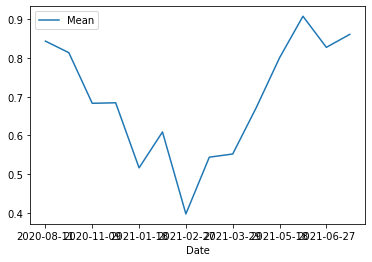

In [9]:
table.plot(x='Date', y='Mean')

**Visualize mean, maximum and minimum NDVI values**

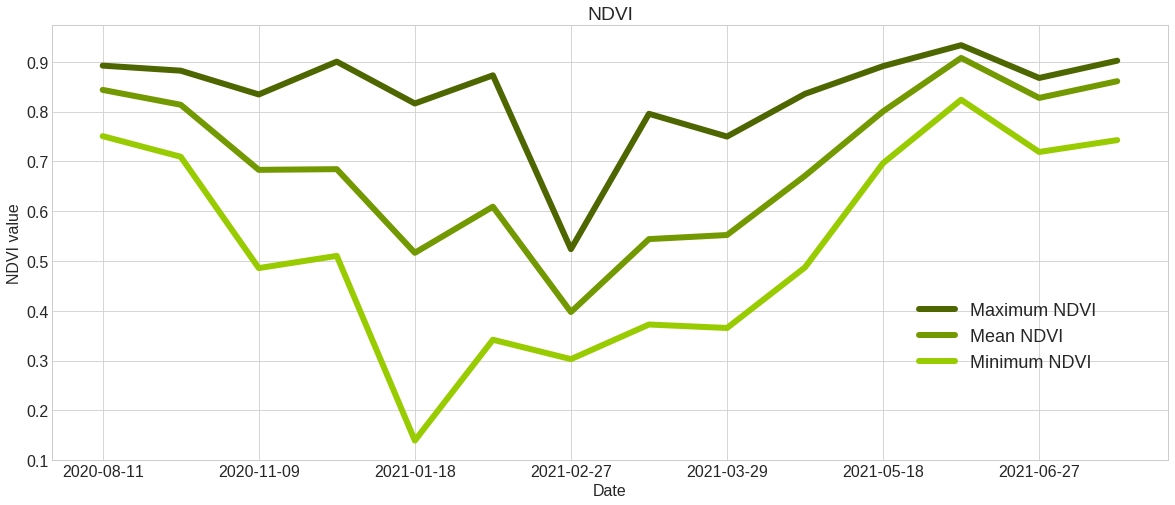

In [18]:
matplotlib.rcParams.update({'font.size': 16})

fig, ax = plt.subplots()
fig.set_size_inches(20,8)
ax.ticklabel_format(style='plain')
plt.style.use('seaborn-whitegrid')

line1 = table.plot(color='#4d6600', kind='line',x='Date',y='Max',ax=ax, label='Maximum NDVI', linewidth=6)
line2 = table.plot(color='#739900', kind='line',x='Date',y='Mean',ax=ax, label='Mean NDVI', linewidth=6)
line3 = table.plot(color='#99cc00', kind='line',x='Date',y='Min',ax=ax, label='Minimum NDVI', linewidth=6)

plt.xlabel('Date')
plt.ylabel('NDVI value')
plt.title('NDVI')
plt.legend(loc='best', bbox_to_anchor=(0.5, 0.2, 0.45, 0.2), shadow=True, prop={'size': 18})

**Fill in the area between max and min**

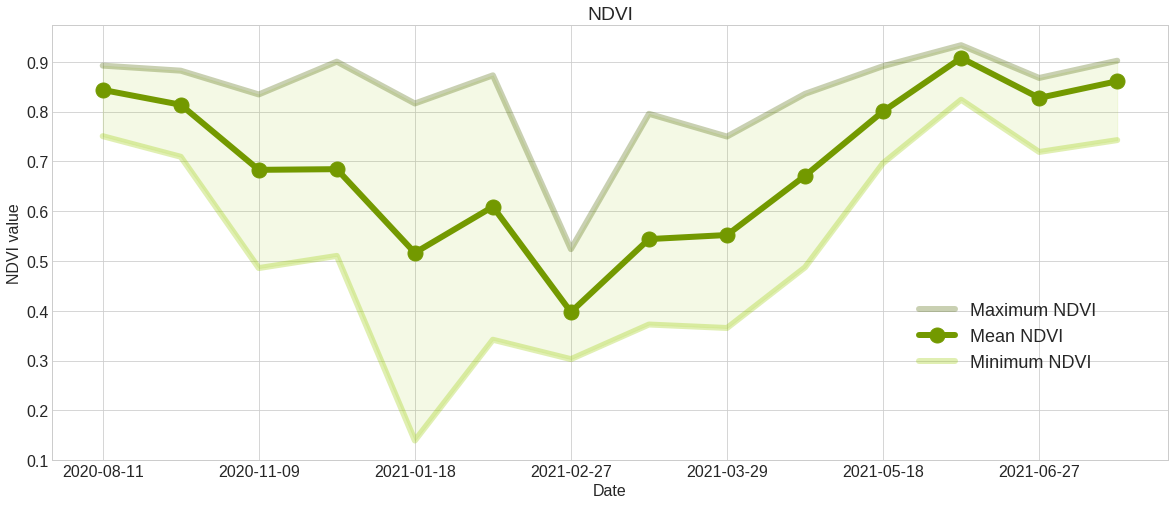

In [20]:
import matplotlib.pyplot as plt
import numpy as np
matplotlib.rcParams.update({'font.size': 16})
factor = 1000000

fig, ax = plt.subplots()
fig.set_size_inches(20,8)
ax.ticklabel_format(style='plain')
plt.style.use('seaborn-whitegrid')

x = table['Date']
y1 = table['Max']
y4 = table['Min']

line1 = table.plot(color='#4d6600', alpha=0.3, kind='line',x='Date',y='Max',ax=ax, label='Maximum NDVI', linewidth=6)
line2 = table.plot(color='#739900', kind='line',x='Date',y='Mean',ax=ax, label='Mean NDVI', linewidth=6, marker='o', markersize=15)
line3 = table.plot(color='#99cc00', alpha = 0.3, kind='line',x='Date',y='Min',ax=ax, label='Minimum NDVI', linewidth=6)

plt.fill_between(x, y1, y4, color='#99cc00', alpha=0.1)


plt.xlabel('Date')
plt.ylabel('NDVI value')
plt.title('NDVI')
plt.legend(loc='best', bbox_to_anchor=(0.5, 0.2, 0.45, 0.2), shadow=True, prop={'size': 18})

plt.savefig('ndvi-mix-1.png')

## Retrieve and visualize statistics for both indices

Here we wanted to show how you can append statistical data for several outputs into the same table. 

### Retrieve statistics for NDVI and BSI

In this part we did the same thing as before, just that we repeated the process for both indices and appended BSI data to our arrays as well. 

In [12]:
# Create empty arrays that will be filled in later
index = []
date = []
Mean = []
Min = []
Max = []

# Find ndvi values
for data_item in sh_statistics['data']:
    for band, value in data_item['outputs']['ndvi']['bands'].items(): 
        index.append(band)
        Mean.append(value ['stats']['mean'])            # Find mean values and append them to the mean array  
        Min.append(value ['stats']['max'])              # Find max values and append them to the max array                                  
        Max.append(value ['stats']['min'])              # Find min values and append them to the min array
        
# Find bsi values
for data_item in sh_statistics['data']:
    for band, value in data_item['outputs']['bsi']['bands'].items(): 
        index.append(band)
        Mean.append(value ['stats']['mean'])            # Find mean values and append them to the mean array  
        Min.append(value ['stats']['max'])              # Find max values and append them to the max array                                  
        Max.append(value ['stats']['min'])              # Find min values and append them to the min array

# Find "date to" for each ndvi entry
for data_item in sh_statistics['data']:
    for band in data_item['outputs']['ndvi']['bands'].items():  # For each band found
        date.append(data_item['interval']['to'])                # Find and append "date to" values to the date array
        date[:] = (elem[:10] for elem in date)                  # Limit each date string to the first 10 characters to keep a readable date format

# Find "date to" for each bsi entry
for data_item in sh_statistics['data']:
    for band in data_item['outputs']['bsi']['bands'].items():  # For each band found
        date.append(data_item['interval']['to'])                # Find and append "date to" values to the date array
        date[:] = (elem[:10] for elem in date)                  # Limit each date string to the first 10 characters to keep a readable date format
        
# Print out the data arrays
print (date)
print(index)
print (Mean)
print (Min)
print (Max)

['2020-08-11', '2020-09-20', '2020-11-09', '2020-11-29', '2021-01-18', '2021-02-17', '2021-02-27', '2021-03-09', '2021-03-29', '2021-04-08', '2021-05-18', '2021-06-17', '2021-06-27', '2021-07-07', '2020-08-11', '2020-09-20', '2020-11-09', '2020-11-29', '2021-01-18', '2021-02-17', '2021-02-27', '2021-03-09', '2021-03-29', '2021-04-08', '2021-05-18', '2021-06-17', '2021-06-27', '2021-07-07']
['NDVI', 'NDVI', 'NDVI', 'NDVI', 'NDVI', 'NDVI', 'NDVI', 'NDVI', 'NDVI', 'NDVI', 'NDVI', 'NDVI', 'NDVI', 'NDVI', 'BSI', 'BSI', 'BSI', 'BSI', 'BSI', 'BSI', 'BSI', 'BSI', 'BSI', 'BSI', 'BSI', 'BSI', 'BSI', 'BSI']
[0.8437445996058478, 0.8138526516467535, 0.6830975254775392, 0.6844527571100473, 0.516412826646887, 0.609049283630678, 0.3974006404037584, 0.5439309637969332, 0.5521596287116568, 0.6712415874359907, 0.800618395435578, 0.9079555950557855, 0.8276296372721363, 0.8611833145458123, -0.27758398120354194, -0.2468917381963866, -0.017572231820642846, 0.000844104062628714, -0.11789178762385046, 0.062418

### Display the table with statistics for both indices

In [13]:
elements = {
    'Index': index,
    'Date': date,
    'Mean': Mean,
    'Max' : Max,
    'Min' : Min,
}

In [14]:
table = pd.DataFrame(elements)
print (table)

   Index        Date      Mean       Max       Min
0   NDVI  2020-08-11  0.843745  0.750795  0.892506
1   NDVI  2020-09-20  0.813853  0.709407  0.882353
2   NDVI  2020-11-09  0.683098  0.485714  0.834568
3   NDVI  2020-11-29  0.684453  0.510180  0.900508
4   NDVI  2021-01-18  0.516413  0.139191  0.816419
5   NDVI  2021-02-17  0.609049  0.341706  0.873016
6   NDVI  2021-02-27  0.397401  0.302762  0.523727
7   NDVI  2021-03-09  0.543931  0.372294  0.795699
8   NDVI  2021-03-29  0.552160  0.365323  0.750000
9   NDVI  2021-04-08  0.671242  0.487233  0.835853
10  NDVI  2021-05-18  0.800618  0.696552  0.891507
11  NDVI  2021-06-17  0.907956  0.823949  0.933567
12  NDVI  2021-06-27  0.827630  0.719004  0.867724
13  NDVI  2021-07-07  0.861183  0.742835  0.902394
14   BSI  2020-08-11 -0.277584 -0.404448 -0.094836
15   BSI  2020-09-20 -0.246892 -0.440608 -0.054101
16   BSI  2020-11-09 -0.017572 -0.290616  0.265128
17   BSI  2020-11-29  0.000844 -0.405701  0.297101
18   BSI  2021-01-18 -0.117892 

### Split the table

This step is needed if you have a table with statistics for several outputs and bands. To visualize specific parts of the table on a chart, the table needs to be split. However, this is just illustratory, as for our example, we could simply just create 2 separate tables in the first place. 

In [15]:
NDVItable = table.loc[table['Index'] == 'NDVI']
BSItable = table.loc[table['Index'] == 'BSI']

In [16]:
print (NDVItable)
print (BSItable)

   Index        Date      Mean       Max       Min
0   NDVI  2020-08-11  0.843745  0.750795  0.892506
1   NDVI  2020-09-20  0.813853  0.709407  0.882353
2   NDVI  2020-11-09  0.683098  0.485714  0.834568
3   NDVI  2020-11-29  0.684453  0.510180  0.900508
4   NDVI  2021-01-18  0.516413  0.139191  0.816419
5   NDVI  2021-02-17  0.609049  0.341706  0.873016
6   NDVI  2021-02-27  0.397401  0.302762  0.523727
7   NDVI  2021-03-09  0.543931  0.372294  0.795699
8   NDVI  2021-03-29  0.552160  0.365323  0.750000
9   NDVI  2021-04-08  0.671242  0.487233  0.835853
10  NDVI  2021-05-18  0.800618  0.696552  0.891507
11  NDVI  2021-06-17  0.907956  0.823949  0.933567
12  NDVI  2021-06-27  0.827630  0.719004  0.867724
13  NDVI  2021-07-07  0.861183  0.742835  0.902394
   Index        Date      Mean       Max       Min
14   BSI  2020-08-11 -0.277584 -0.404448 -0.094836
15   BSI  2020-09-20 -0.246892 -0.440608 -0.054101
16   BSI  2020-11-09 -0.017572 -0.290616  0.265128
17   BSI  2020-11-29  0.000844 

### Visualize both mean NDVI and BSI values on a line chart

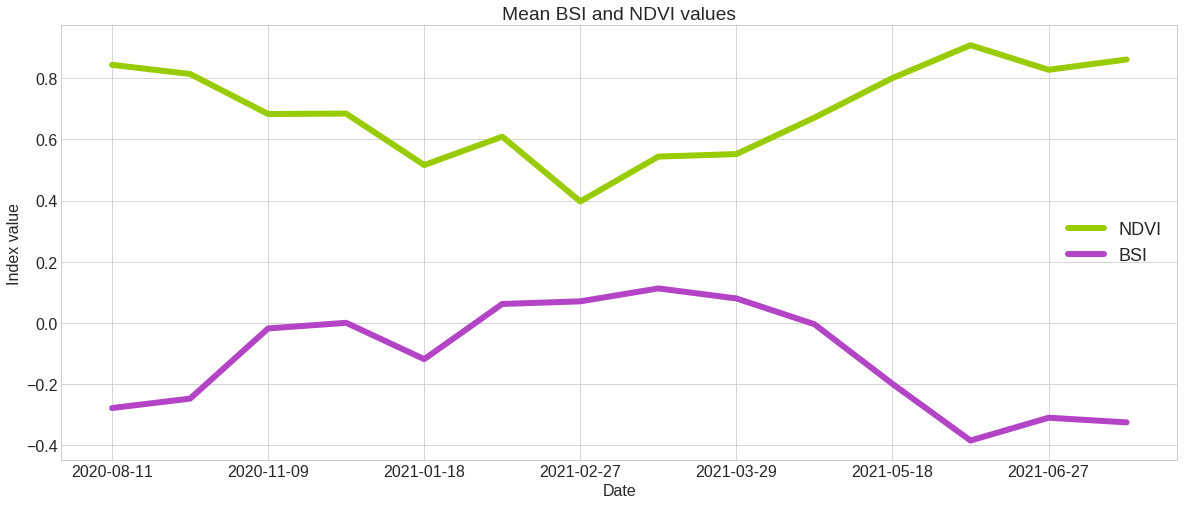

In [17]:
matplotlib.rcParams.update({'font.size': 16})
factor = 1000000

fig, ax = plt.subplots()
fig.set_size_inches(20,8)
ax.ticklabel_format(style='plain')
plt.style.use('seaborn-darkgrid')

line1 = NDVItable.plot(color='#99cc00', kind='line',x='Date',y='Mean',ax=ax, label='NDVI', linewidth=6)
line1 = BSItable.plot(color='#B344C6', kind='line',x='Date',y='Mean',ax=ax, label='BSI', linewidth=6)


plt.xlabel('Date')
plt.ylabel('Index value')
plt.title('Mean BSI and NDVI values')
plt.legend(loc="best", shadow=True, prop={'size': 18})

plt.savefig('ndvi-1.png')

## Histograms

### NDVI statistics with a histogram for 1 month, 10 bins

The following is a JSON response of the statistical request, that calculates NDVI statistics for one month. A histogram with 10 bins has also been requested.

In [ ]:
from sentinelhub import SHConfig, SentinelHubStatistical, BBox, Geometry, DataCollection, CRS

# Credentials
config = SHConfig()
config.sh_client_id = client_id
config.sh_client_secret = client_secret

evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "data",
        bands: ["NDVI"]
      },
      {
        id: "dataMask",
        bands: 1
      }]
  }
}

function evaluatePixel(samples) {
    let ndvi = (samples.B08 - samples.B04)/(samples.B08 + samples.B04)
    
    var validNDVIMask = 1
    if (samples.B08 + samples.B04 == 0 ){
        validNDVIMask = 0
    }
    
    var noWaterMask = 1
    if (samples.SCL == 6 ){
        noWaterMask = 0
    }

    return {
        data: [ndvi],
        // Exclude nodata pixels, pixels where ndvi is not defined and water pixels from statistics:
        dataMask: [samples.dataMask * validNDVIMask * noWaterMask]
    }
}
"""

calculations = {
    "default": {
        "histograms": {
            "default": {
                "nBins": 10
            }
        }
    }
}

bbox = BBox(bbox=[14.43807, 45.978388, 14.449997, 45.986768], crs=CRS.WGS84)
geometry = Geometry(geometry={"type":"Polygon","coordinates":[[[14.43807,45.985337],[14.442789,45.978716],[14.444548,45.979045],[14.445106,45.978388],[14.449997,45.980118],[14.445707,45.983846],[14.443089,45.98322],[14.44236,45.984204],[14.444591,45.984621],[14.442789,45.986768],[14.43807,45.985337]]]}, crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2021-01-01T00:00:00Z', '2021-02-01T23:59:59Z'),
        aggregation_interval='P1M',
        size=[512, 517.657],        
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L2A,                        
      ),
    ],
    bbox=bbox,
    geometry=geometry,
    calculations=calculations,
    config=config
)

response = request.get_data()

Just to illustrate the possibility, if you saved the API response, you can simply paste it in and name it as a variable instead of running the request all over again.

In [19]:
json = {'data': [{'interval': {'from': '2021-01-01T00:00:00Z',
     'to': '2021-02-01T00:00:00Z'},
    'outputs': {'data': {'bands': {'NDVI': {'stats': {'min': -0.009306260384619236,
         'max': 0.05112960934638977,
         'mean': 0.019889125026077203,
         'stDev': 0.007759267052060924,
         'sampleCount': 264704,
         'noDataCount': 141236},
        'histogram': {'bins': [{'lowEdge': -0.009306260384619236,
           'highEdge': -0.0032626734115183357,
           'count': 181},
          {'lowEdge': -0.0032626734115183357,
           'highEdge': 0.0027809135615825646,
           'count': 1432},
          {'lowEdge': 0.0027809135615825646,
           'highEdge': 0.008824500534683463,
           'count': 7084},
          {'lowEdge': 0.008824500534683463,
           'highEdge': 0.014868087507784365,
           'count': 23004},
          {'lowEdge': 0.014868087507784365,
           'highEdge': 0.020911674480885267,
           'count': 37390},
          {'lowEdge': 0.020911674480885267,
           'highEdge': 0.026955261453986162,
           'count': 33437},
          {'lowEdge': 0.026955261453986162,
           'highEdge': 0.032998848427087064,
           'count': 15122},
          {'lowEdge': 0.032998848427087064,
           'highEdge': 0.039042435400187966,
           'count': 4310},
          {'lowEdge': 0.039042435400187966,
           'highEdge': 0.04508602237328887,
           'count': 1203},
          {'lowEdge': 0.04508602237328887,
           'highEdge': 0.05112960934638977,
           'count': 305}],
         'overflowCount': 0,
         'underflowCount': 0}}}}}}],
  'status': 'OK'}

### Retrieve the histogram and its values

Here we searched the resulting JSON to find the histogram part of the response. As you can see, each bin has a number of pixels that fall into it, as well as lowEdge and highEdge values, which specify where each bin begins and ends.

In [21]:
json['data'][0]['outputs']['data']['bands']['NDVI']['histogram']['bins']

[{'lowEdge': -0.009306260384619236,
  'highEdge': -0.0032626734115183357,
  'count': 181},
 {'lowEdge': -0.0032626734115183357,
  'highEdge': 0.0027809135615825646,
  'count': 1432},
 {'lowEdge': 0.0027809135615825646,
  'highEdge': 0.008824500534683463,
  'count': 7084},
 {'lowEdge': 0.008824500534683463,
  'highEdge': 0.014868087507784365,
  'count': 23004},
 {'lowEdge': 0.014868087507784365,
  'highEdge': 0.020911674480885267,
  'count': 37390},
 {'lowEdge': 0.020911674480885267,
  'highEdge': 0.026955261453986162,
  'count': 33437},
 {'lowEdge': 0.026955261453986162,
  'highEdge': 0.032998848427087064,
  'count': 15122},
 {'lowEdge': 0.032998848427087064,
  'highEdge': 0.039042435400187966,
  'count': 4310},
 {'lowEdge': 0.039042435400187966,
  'highEdge': 0.04508602237328887,
  'count': 1203},
 {'lowEdge': 0.04508602237328887,
  'highEdge': 0.05112960934638977,
  'count': 305}]

**Retrieve lowEdge values**

To visualize a histogram, we need its lowEdge values. To do so, we specify empty arrays, then append the values to them. 

In [22]:
# Get lowEdge values and append them to the lowEdge array
array=[]
array2 = []
lowEdge = []

for data_item in json['data']:
    for item, value in data_item['outputs']['data']['bands']['NDVI']['histogram'].items():
        array.append(value)  
        array2 = array[0]
for i in array2:
    lowEdge.append(i['lowEdge'])      
print (lowEdge)

[-0.009306260384619236, -0.0032626734115183357, 0.0027809135615825646, 0.008824500534683463, 0.014868087507784365, 0.020911674480885267, 0.026955261453986162, 0.032998848427087064, 0.039042435400187966, 0.04508602237328887]


**Retrieve count values**

To visualize a histogram, we need its count values. To do so, we specify empty arrays, then append the values to them. 

In [ ]:
# Get count values and append them to the count array
array3=[]
array4 = []
count = []

for data_item in json['data']:
    for item, value in data_item['outputs']['data']['bands']['NDVI']['histogram'].items():
        array3.append(value)  
        array4 = array[0]
for i in array4:
    count.append(i['count'])   
print (count)

**Round lowEdge values, then print out final lowEdge and count values**

In [24]:
print(count)
lowEdge = [round(num, 1) for num in lowEdge]
print(lowEdge) #bins

[181, 1432, 7084, 23004, 37390, 33437, 15122, 4310, 1203, 305]
[-0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### Visualize the NDVI histogram

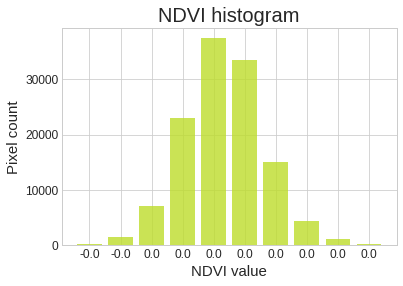

In [25]:
bins = lowEdge
number = count

bins_pos = [i for i, _ in enumerate(bins)]

plt.style.use('seaborn-whitegrid') # nice and clean grid

plt.bar(bins_pos, number, facecolor = '#BDDD2B', linewidth=0.5, alpha=0.8)
plt.xlabel("NDVI value", fontsize=15)
plt.ylabel("Pixel count", fontsize=15)
plt.title("NDVI histogram", fontsize=20)


plt.xticks(bins_pos,bins, fontsize=12)
plt.yticks(fontsize=12)

plt.show()